# Exercise 6 - SIRV Models - Example Solution

In [1]:
import Pkg; 
Pkg.activate(".")

  Activating project at `~/Nextcloud/Exercise6.jl`


In [2]:
using Exercise6

[ Info: Precompiling Exercise6 [ac2159b5-8327-4ca4-b819-655316bc1e51]
┌ Warning: Replacing docs for `Exercise6.SIRVSeasonalContactDecayingImmunity :: NTuple{4, Any}` in module `Exercise6`
└ @ Base.Docs docs/Docs.jl:243


- In this notebook we'll use our package [Exercise6.jl](https://github.com/maximilian-gelbrecht/Exercise6.jl) to explore the dynamics of various SIR models modified to include the effect of vaccination. Remember that there is no single correct solution to this exercise; the aim was simply for you to explore some variations of an SIR model while also gaining experience structuring your code as a proper Julia package. What follows is therefore only one possible approach that could have been taken.


- While using this notebook, it is highly recommend to look closely at the code and the documentation for the package [Exercise6.jl](https://github.com/maximilian-gelbrecht/Exercise6.jl) where the models and plots are implemented.


- When using this notebook remember also that you can inspect the docstrings for any Julia object using `?`. For example:

In [3]:
?SIRV

search: SIRV SIRVSeasonalContact SIRVDecayingImmunity



```
SIRV{T} <: AbstractSIRVModel{T}
```

SIRV model with contact rate $\beta$, recovery rate $\gamma$, vaccination rate $\nu$, and no demography:

$$
\begin{aligned}
\frac{dS}{dt} & = -\beta I S -\nu S\\[8pt]
\frac{dI}{dt} & = \beta I S - \gamma I \\[8pt]
\frac{dR}{dt} & = \gamma I \\[8pt]
\frac{dV}{dt} & = \nu S .
\end{aligned}
$$

Objects of this type are callable with the signature `(du, u, p, t)` which performs an in-place update of the derivatives `du` of the system.

---

```
SIRV(ν) -> SIRV
```

Return an `SIRV` model with vaccination rate $\nu$ and default parameters $\beta = 0.35$ and  $\gamma = 0.035$.

---

```
(::SIRV)(du, u, p, t) -> nothing
```

Update the derivates `du` given a model of type `SIRV`.


- We will use the same initial conditions throughout: 90% of the population susceptible, 5% infected, 5% recovered, and 0% vaccinated.

In [4]:
u0 = [0.9, 0.05, 0.05, 0.0]

4-element Vector{Float64}:
 0.9
 0.05
 0.05
 0.0

- In addition, we'll stick with the same default parameters for the contact rate $\beta = 0.35$ and recovery rate $\gamma = 0.035$ taken from Fig. 1 of [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7321055/pdf/main.pdf).


- Let's start off by looking at the trajectory of a standard SIRV model.

Initial conditions: S(0) = 0.90, I(0) = 0.05, R(0) = 0.05, V(0) = 0.00
Final state:        S(T) = 0.00, I(T) = 0.00, R(T) = 0.91, V(T) = 0.09

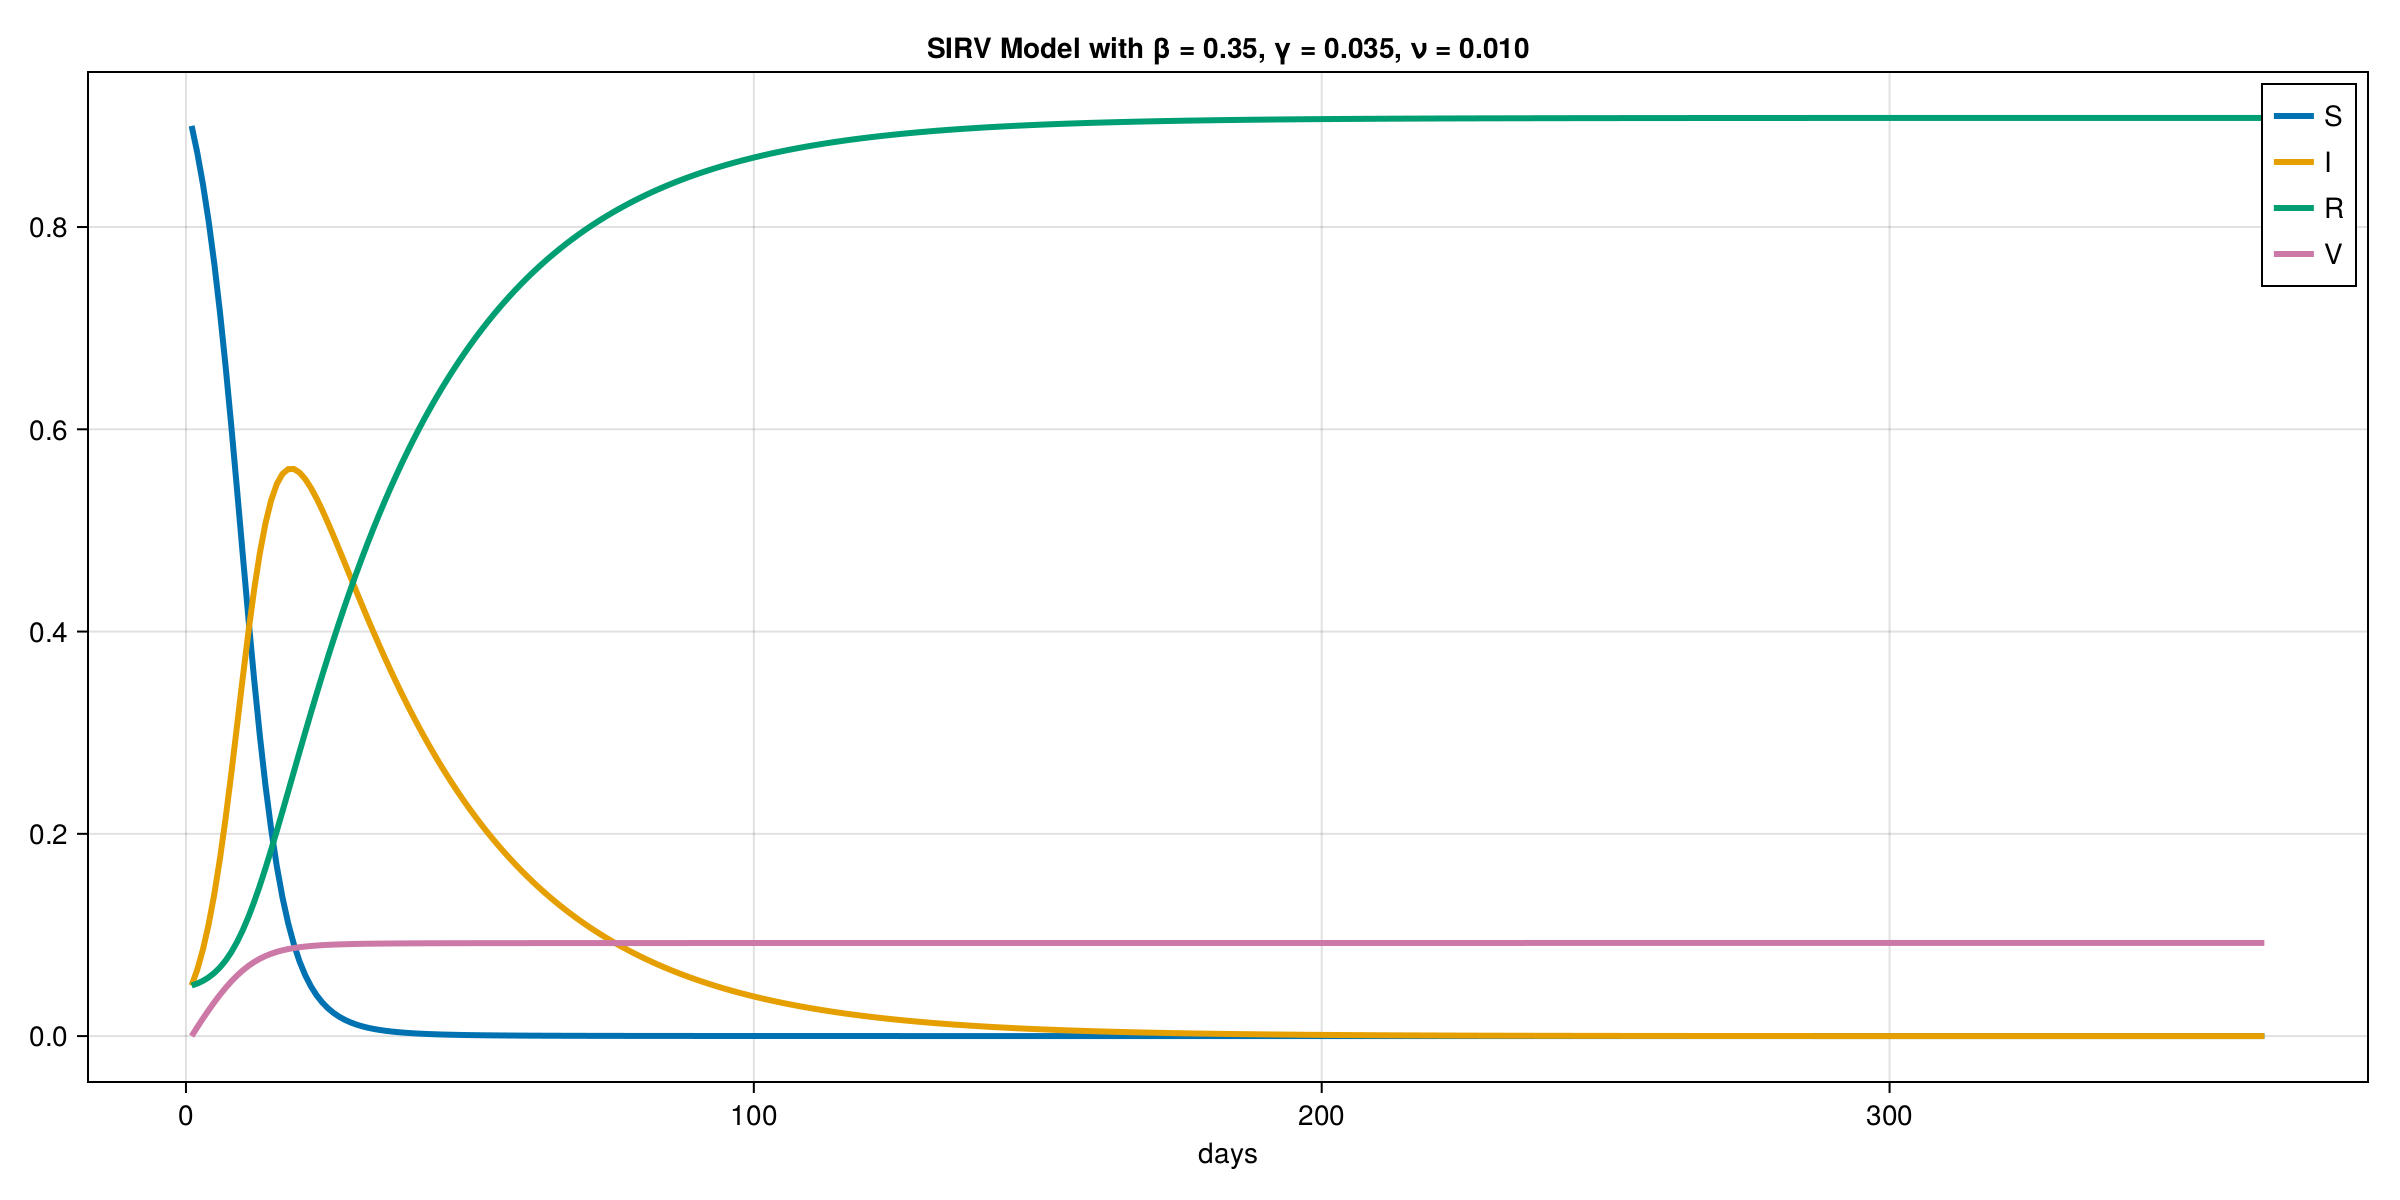

In [5]:
ν = 0.01  # Fraction of the susceptible population vaccinated per day
model = SIRV(ν)
plot(model; u0)

- If we vaccinate 1% of the susceptible population every day, we eventually end up with no infections (remember that the vaccine is assumed 100% effective), but over 90% of the population got their immunity from infection rather than vaccination.


- How about if we could vaccinate 5% of the susceptible population every day?

Initial conditions: S(0) = 0.90, I(0) = 0.05, R(0) = 0.05, V(0) = 0.00
Final state:        S(T) = 0.00, I(T) = 0.00, R(T) = 0.61, V(T) = 0.39

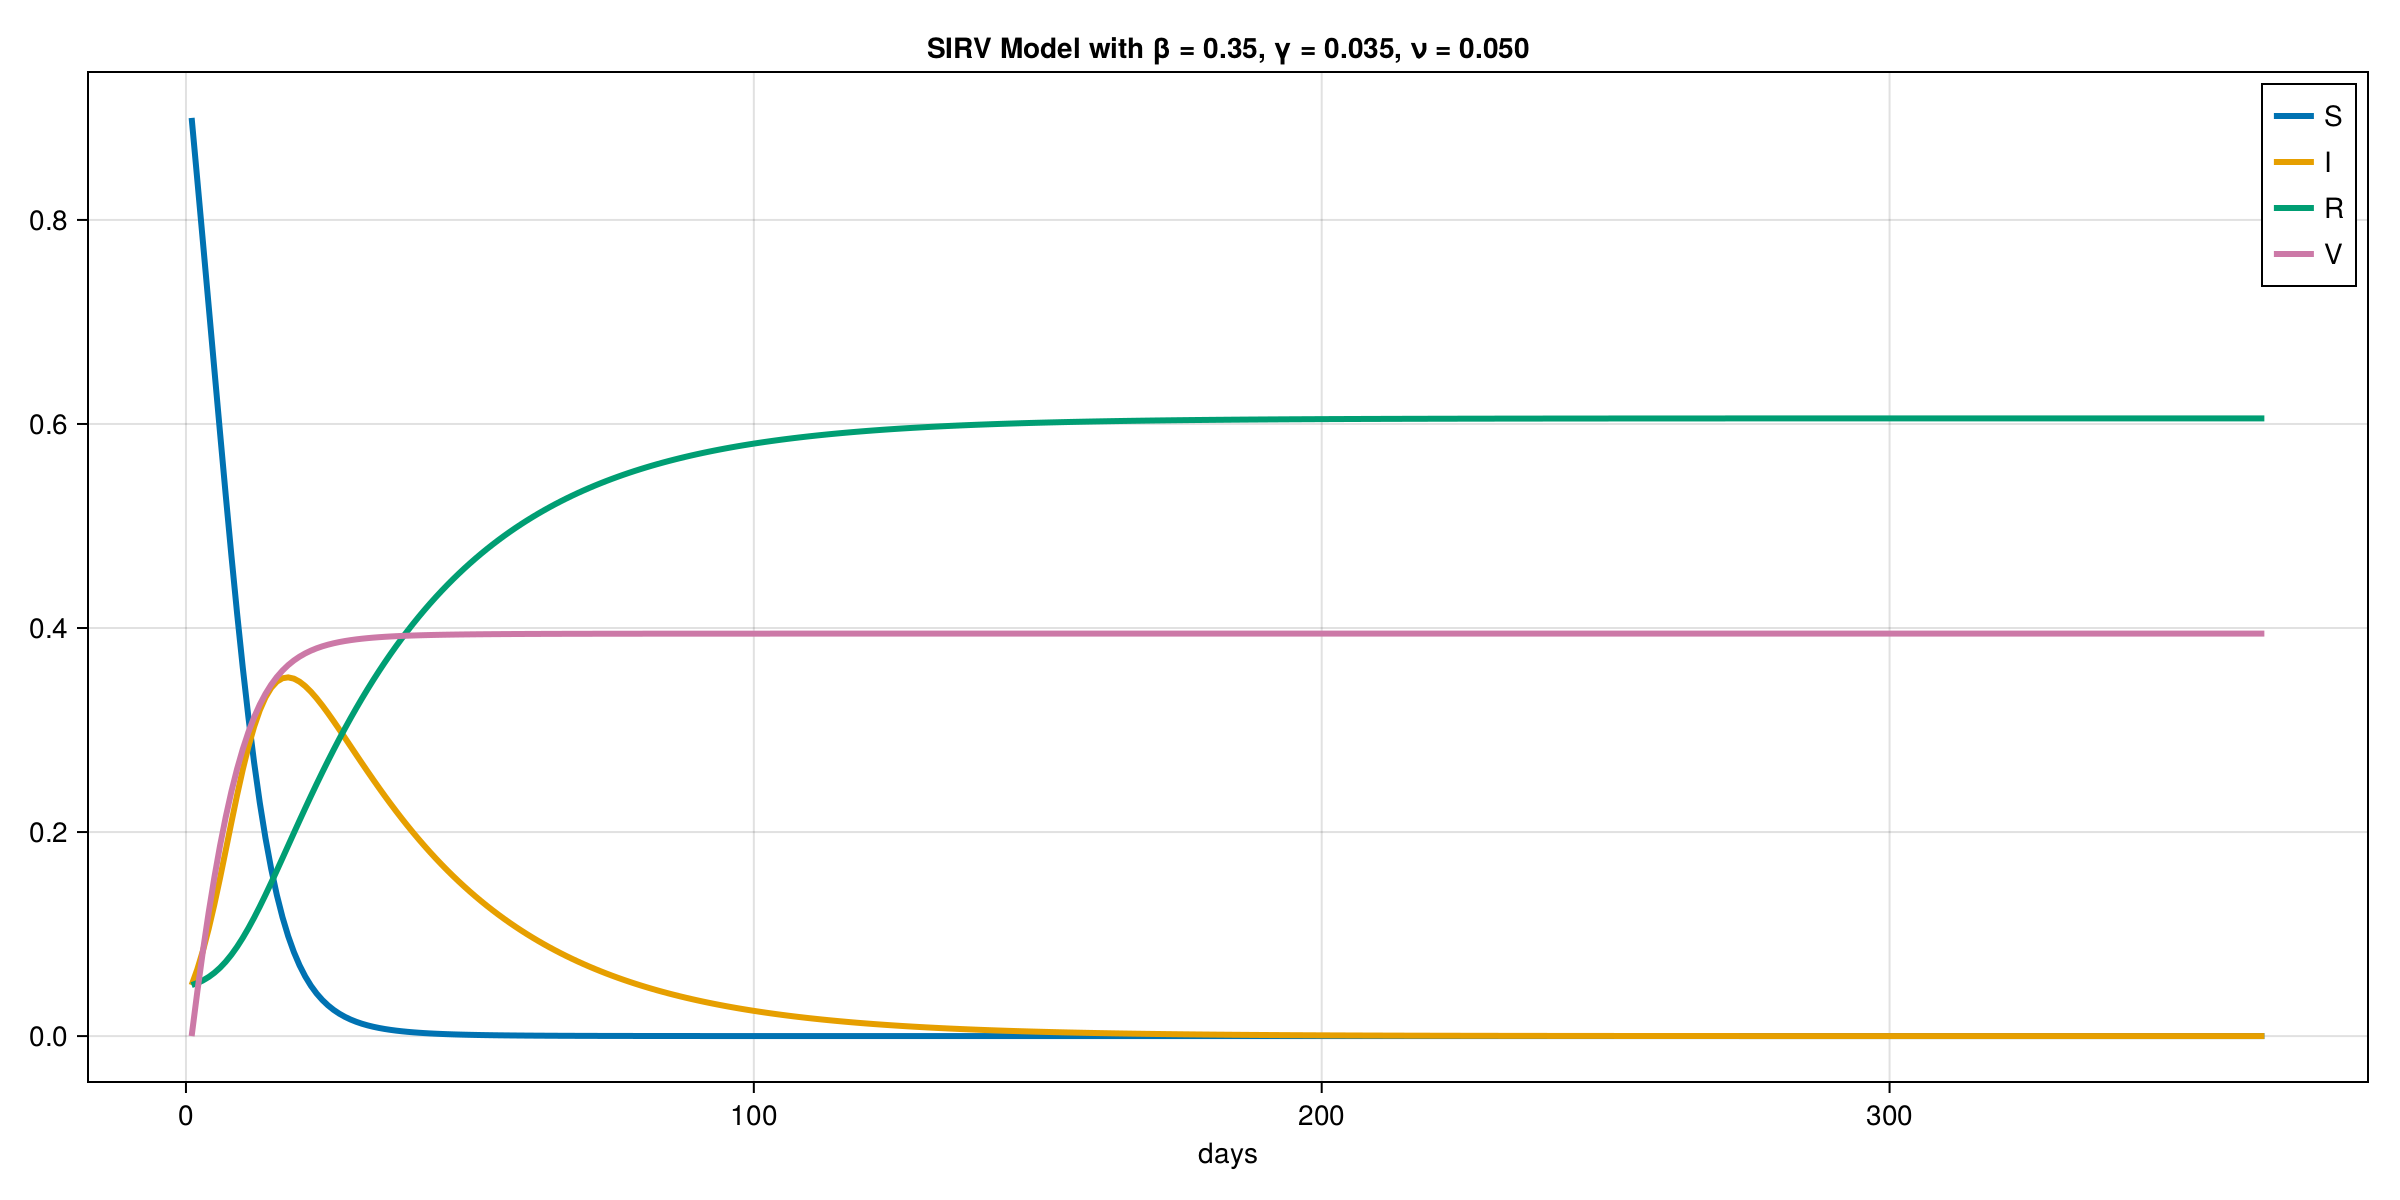

In [6]:
ν = 0.05  # Fraction of the susceptible population vaccinated per day
model = SIRV(ν)
plot(model; u0)

- This is better, with 39% of the population now avoiding infection.


- How fast do we have to vaccinate people in order to beat the pace of infections?

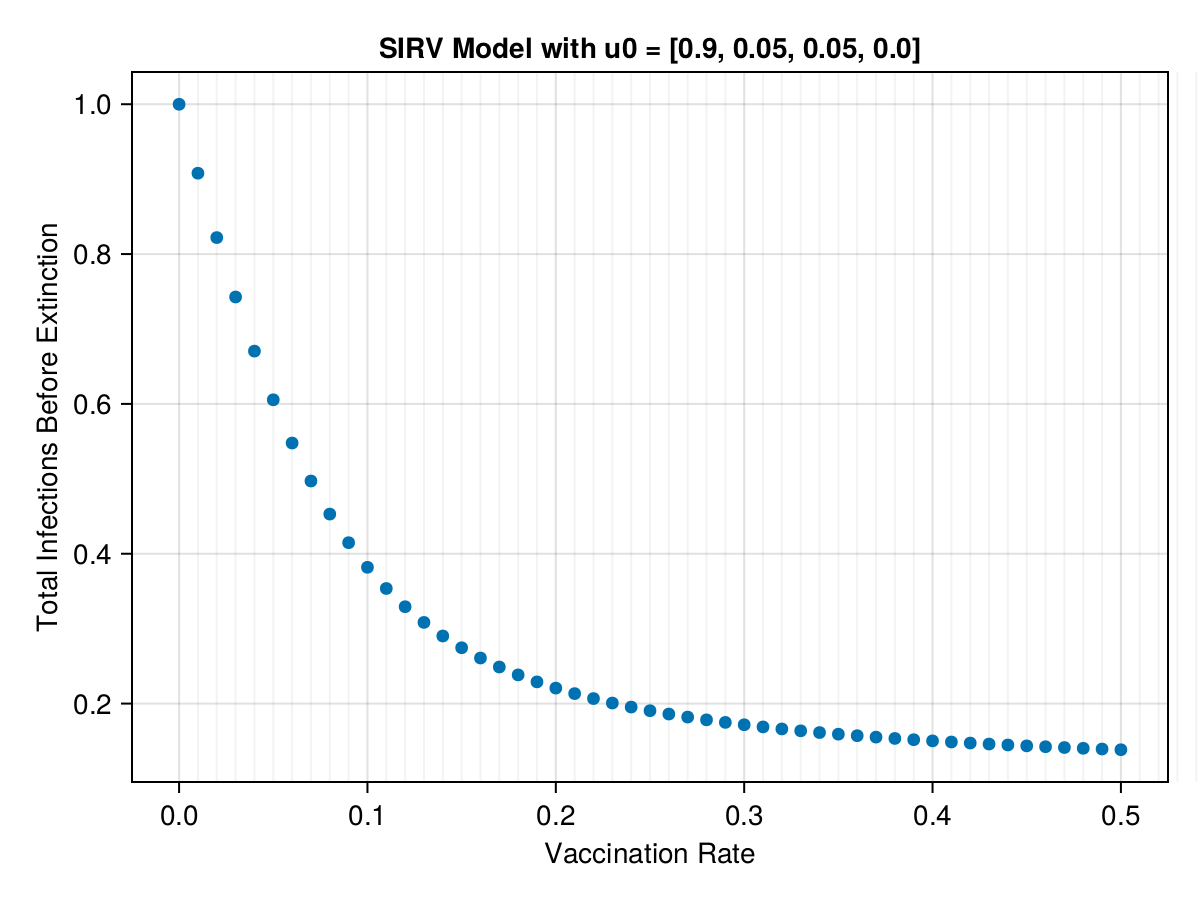

In [7]:
ν_range = 0.0:0.01:0.5
plot_total_infections_by_vax_rate(ν_range; u0)

- We see that, even for very high vaccination rates, a significant proportion of the population still becomes infected before they can get vaccinated.


- Now let's look at what happens when the immunity obtained from both infection and vaccination decays over time. This is implemented by the type `SIRVDecayingImmunity`.

Initial conditions: S(0) = 0.90, I(0) = 0.05, R(0) = 0.05, V(0) = 0.00
Final state:        S(T) = 0.10, I(T) = 0.10, R(T) = 0.62, V(T) = 0.18

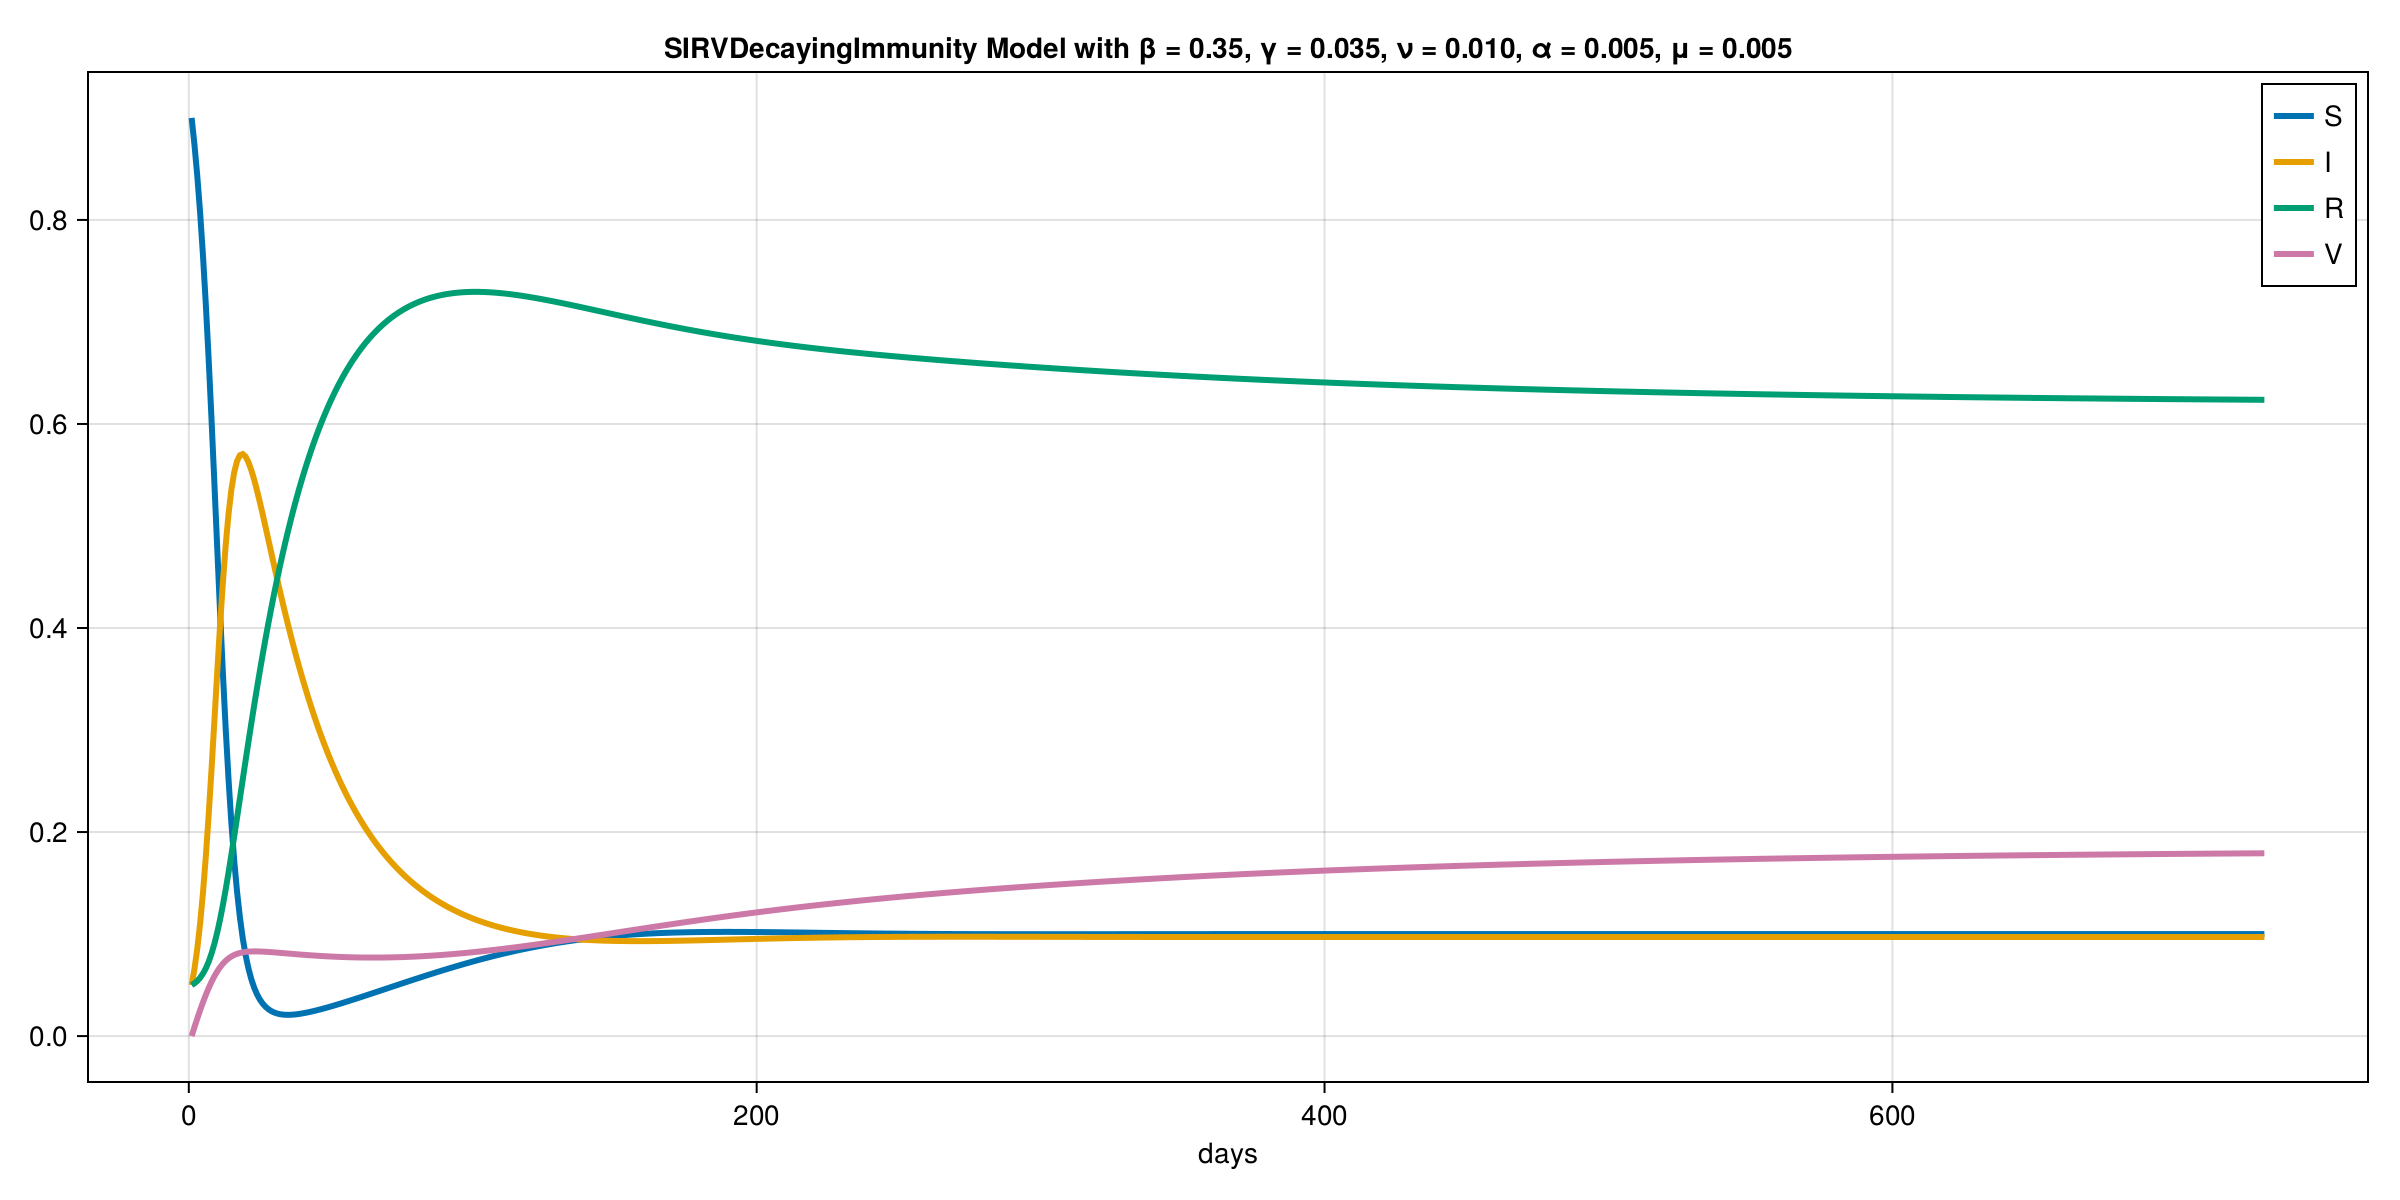

In [8]:
ν = 0.01     # 1% of the susceptible population vaccinated per day
α = 2 / 365  # Immunity from infection decays after half a year, on average
μ = 2 / 365  # Immunity from vaccination decays after half a year, on average
model = SIRVDecayingImmunity(ν, α, μ)
plot(model; u0, endtime = 2 * 365.0)

- For these parameters, the model has a fixed point where 10% of the population is infected at any given time.


- How does the fixed point depend on the vaccination rate $\nu$?

Initial conditions: S(0) = 0.90, I(0) = 0.05, R(0) = 0.05, V(0) = 0.00
Final state:        S(T) = 0.10, I(T) = 0.07, R(T) = 0.52, V(T) = 0.31

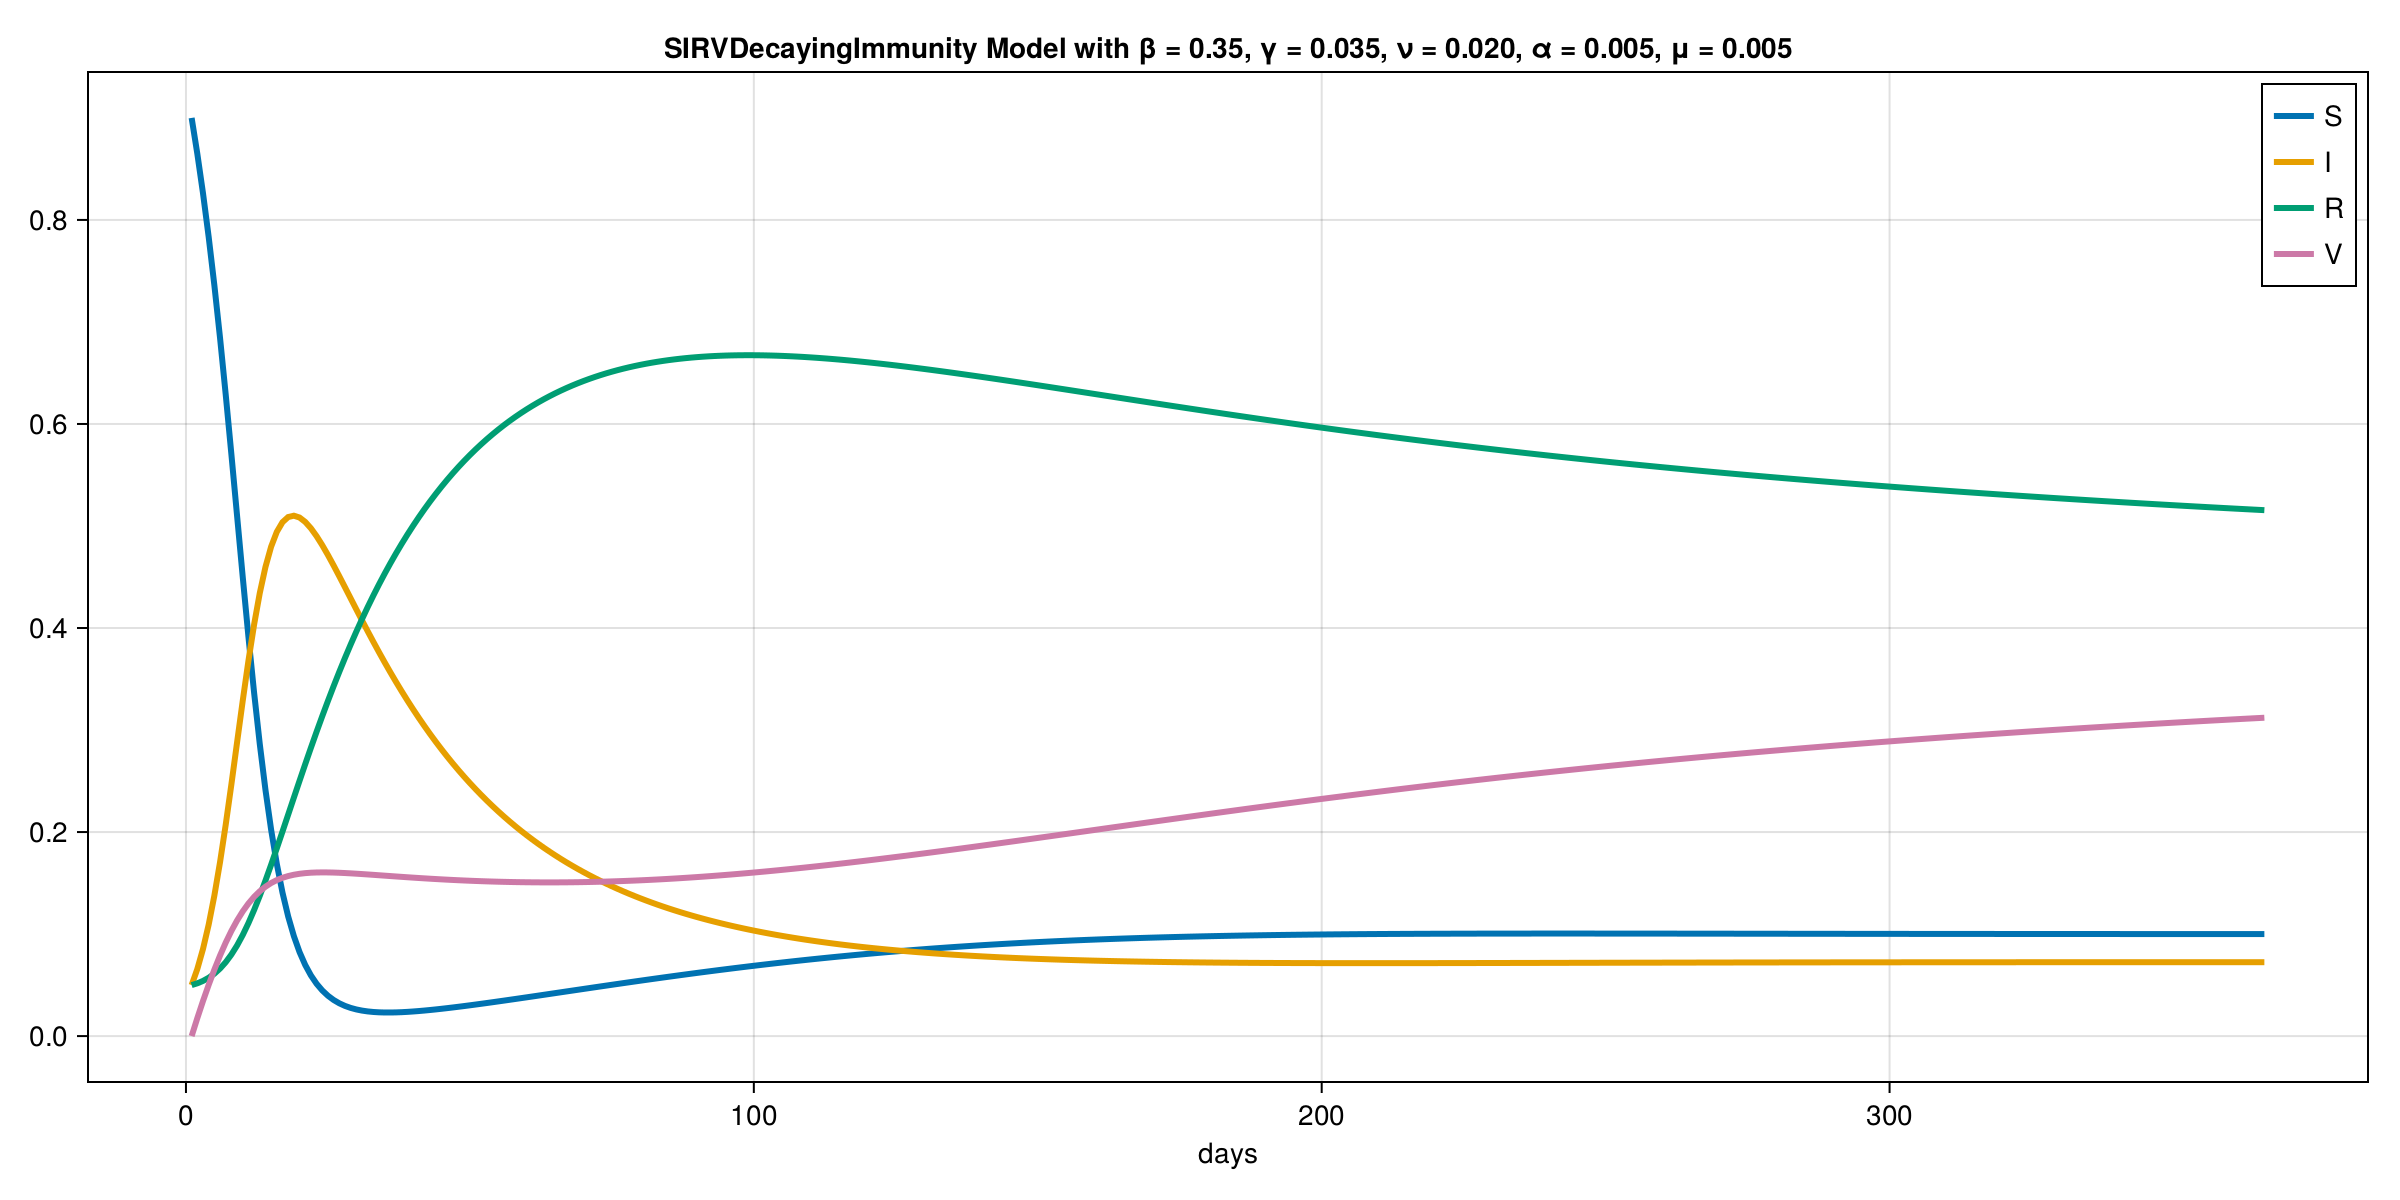

In [9]:
ν = 0.02
model = SIRVDecayingImmunity(ν, α, μ)
plot(model; u0)

- So the endemic equilibrium point depends on the vaccination rate, as we might expect.


- How fast do we have to vaccinate people for the stable fixed point of the model to be a disease-free equilibrium rather than an endemic equilibrium?

Initial conditions: S(0) = 0.90, I(0) = 0.05, R(0) = 0.05, V(0) = 0.00
Final state:        S(T) = 0.08, I(T) = 0.00, R(T) = 0.16, V(T) = 0.76

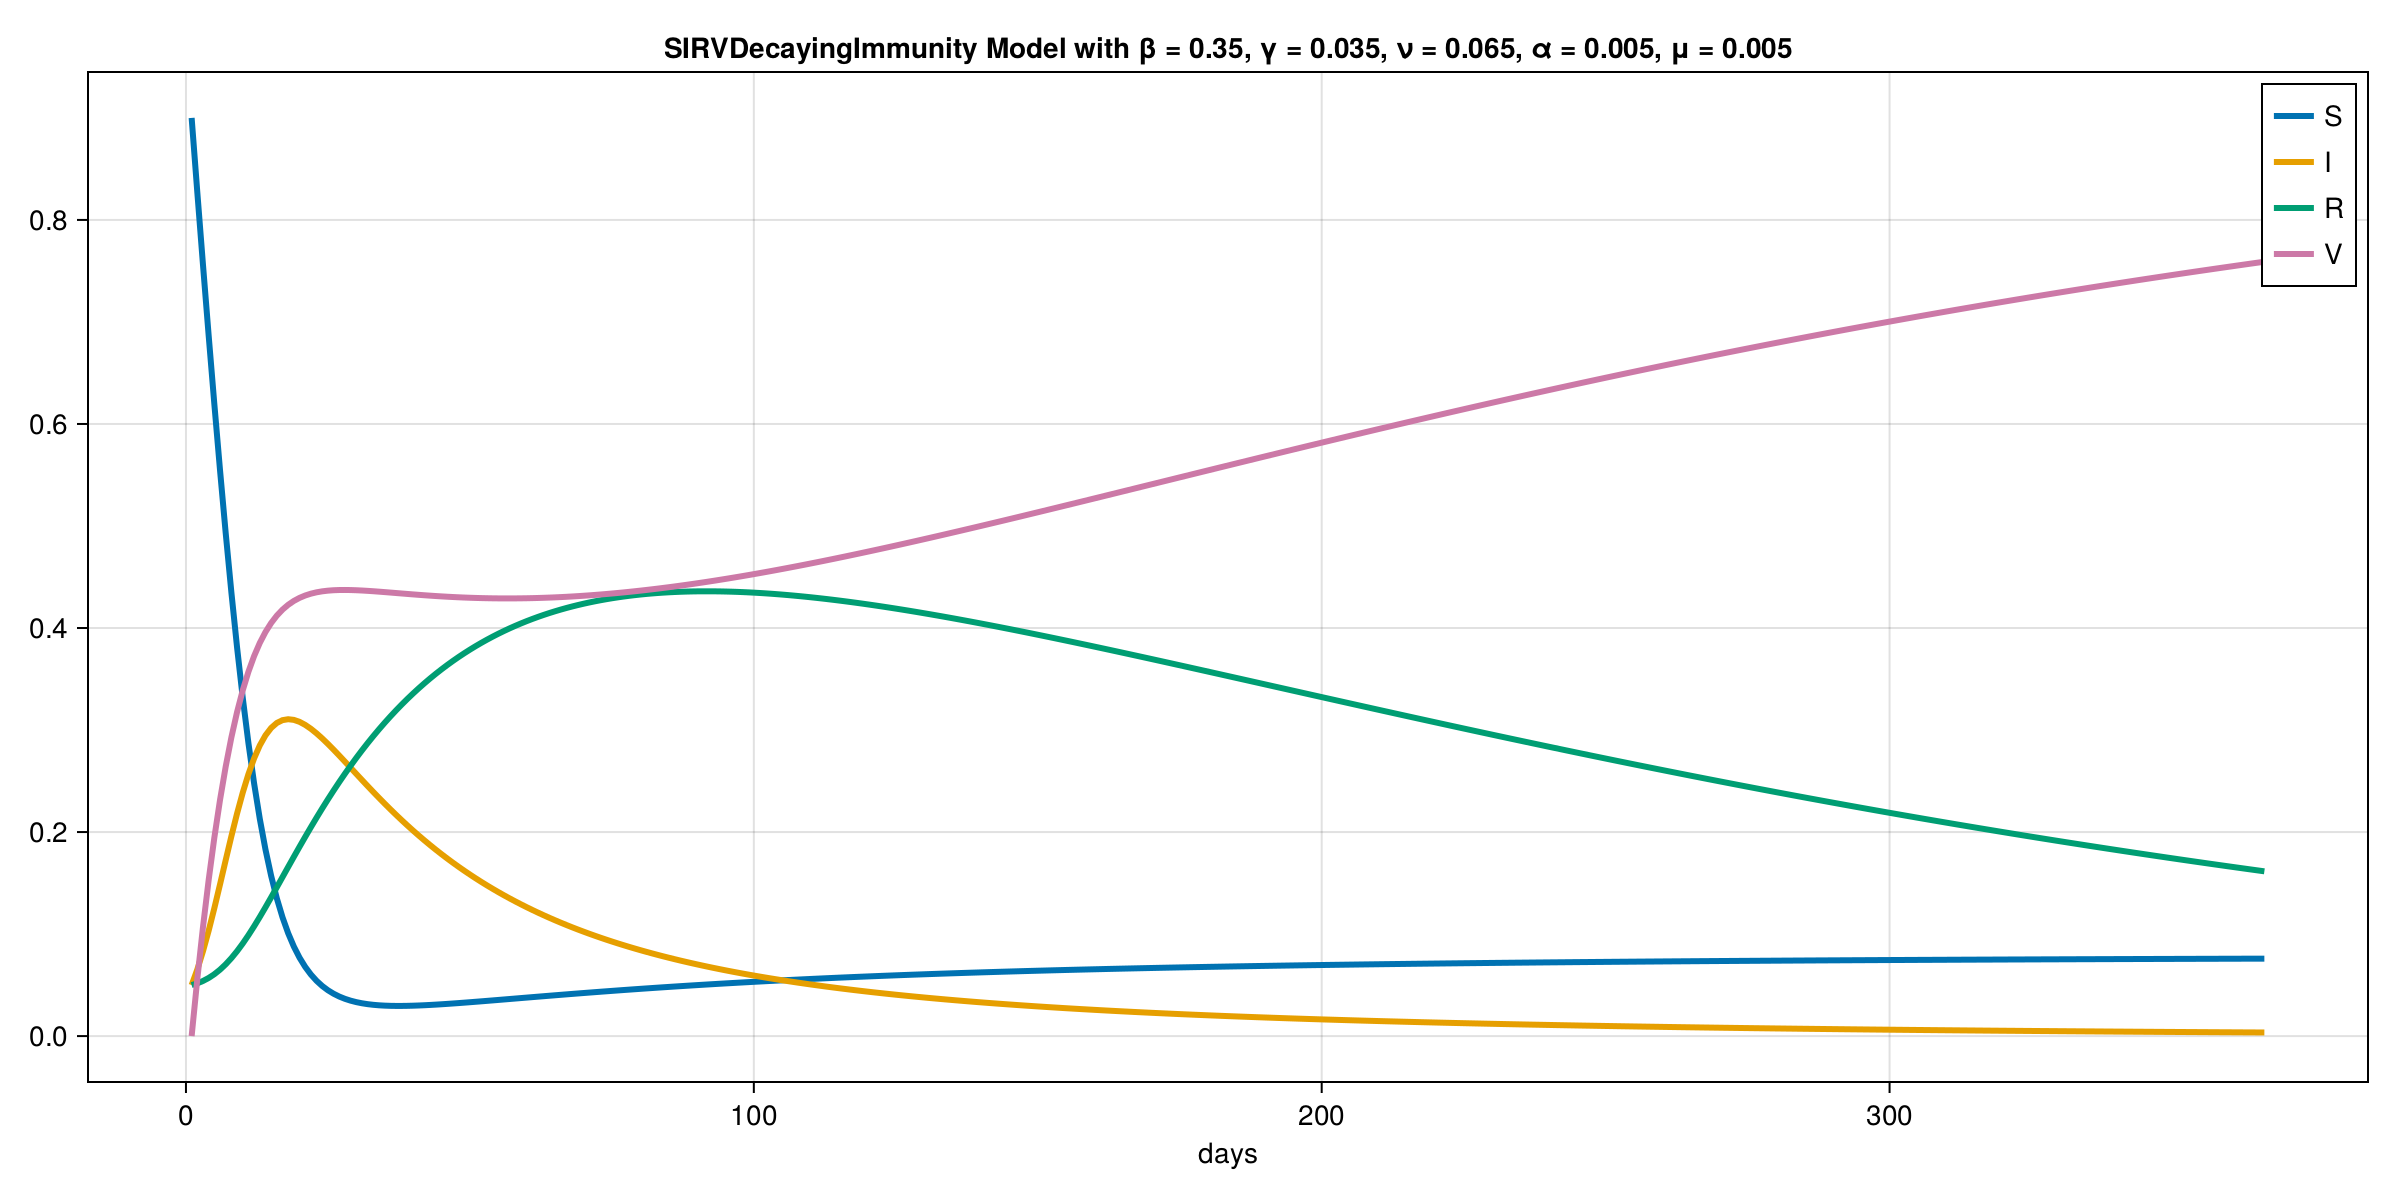

In [10]:
ν = 0.065
model = SIRVDecayingImmunity(ν, α, μ)
plot(model; u0)

- For the disease to go extinct, we have to vaccinate about 6.5% of the susceptible population every day!


- Now let's see what happens when we additionally introduce some seasonality into the contact rate $\beta$.

Initial conditions: S(0) = 0.90, I(0) = 0.05, R(0) = 0.05, V(0) = 0.00
Final state:        S(T) = 0.09, I(T) = 0.10, R(T) = 0.62, V(T) = 0.18

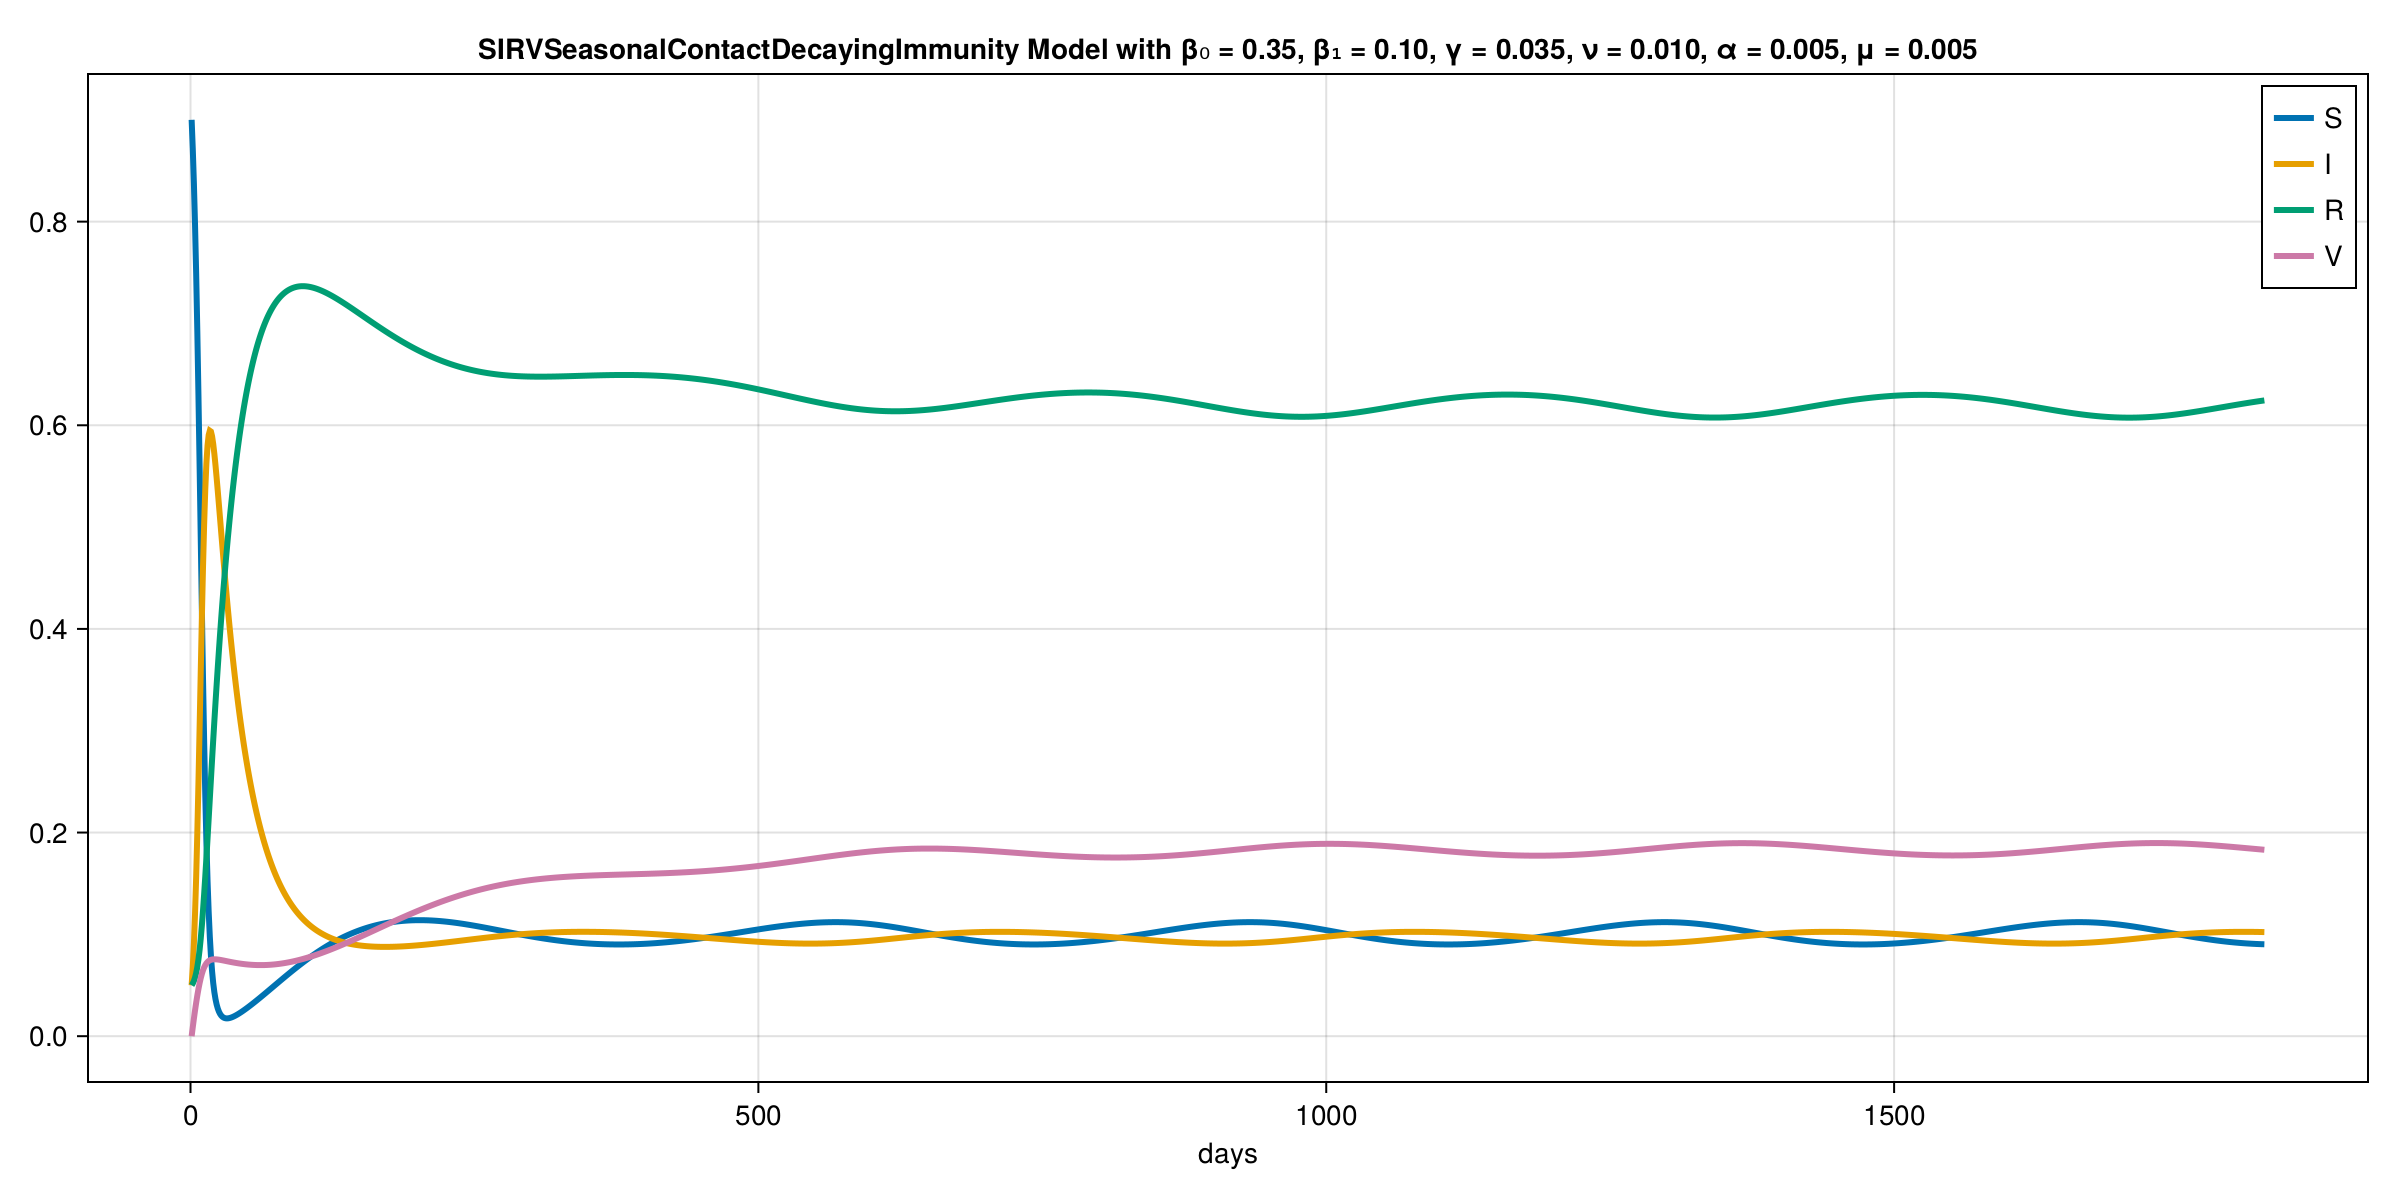

In [11]:
β₁ = 0.1     # Max 10% variation around the average contact rate
ν = 0.01     # 1% of the susceptible population vaccinated per day
α = 2 / 365  # Immunity from infection decays after half a year, on average
μ = 2 / 365  # Immunity from vaccination decays after half a year, on average

model = SIRVSeasonalContactDecayingImmunity(β₁, ν, α, μ)
plot(model; u0, endtime = 5 * 365.0)

- Now we observe oscillations in the infection level, with around 10% of the population being infected at any given time.


- Let's look at this in phase space.

Initial conditions: S(0) = 0.10, I(0) = 0.10, R(0) = 0.23, V(0) = 0.57

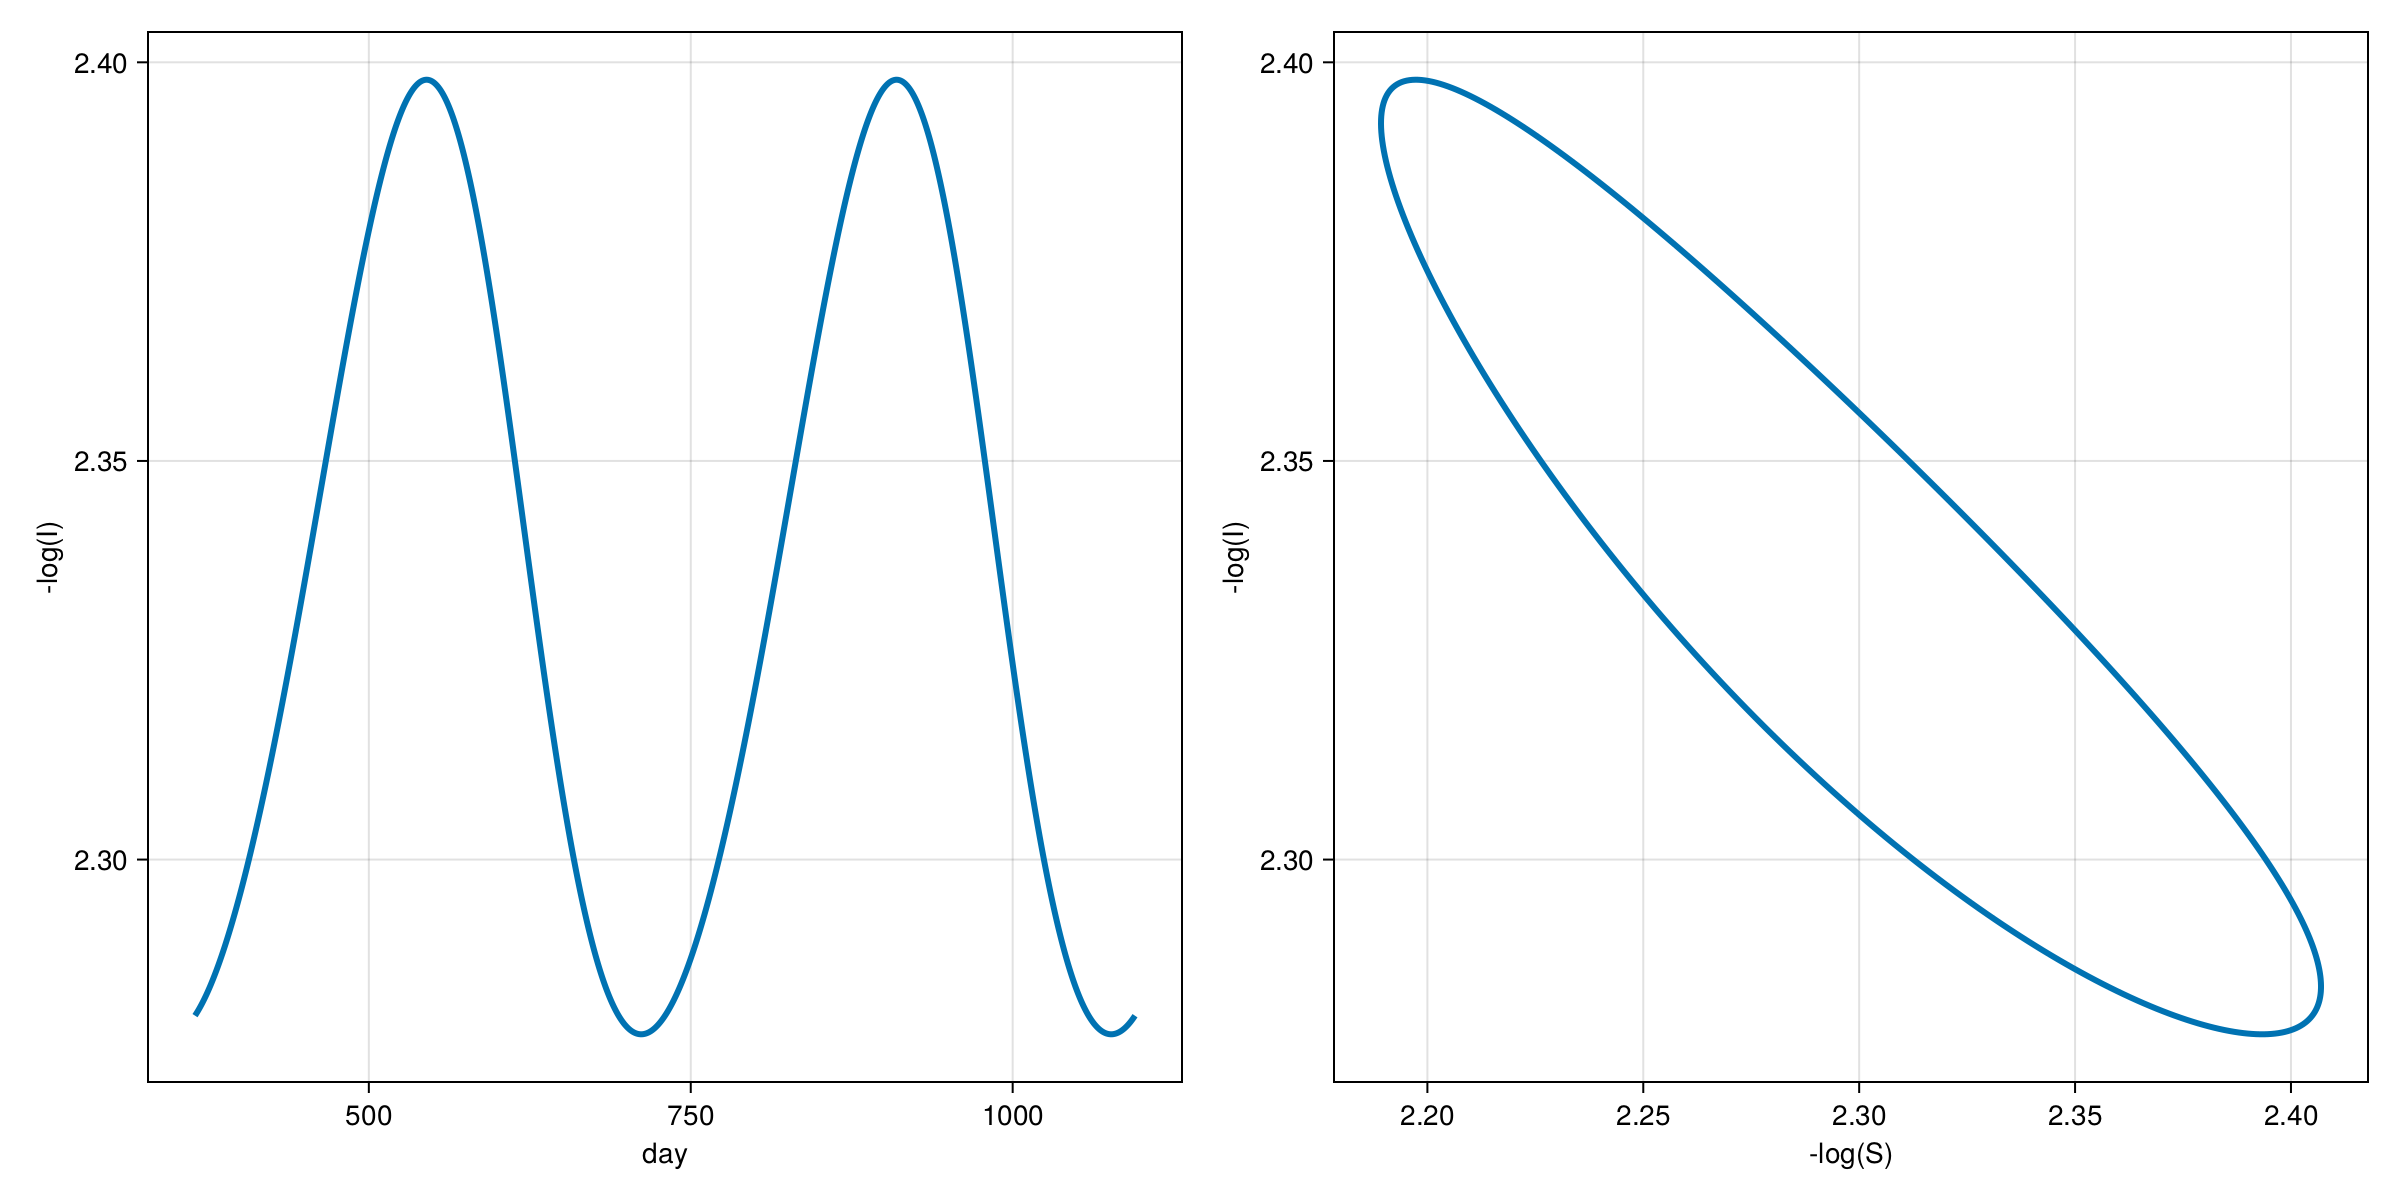

In [12]:
plot_phase_diagram(model, endtime = 2 * 365.0, Ttr = 365.0)

- Can we observe any bifurcations, like we did in the lecture?

Initial conditions: S(0) = 0.21, I(0) = 0.11, R(0) = 0.19, V(0) = 0.48

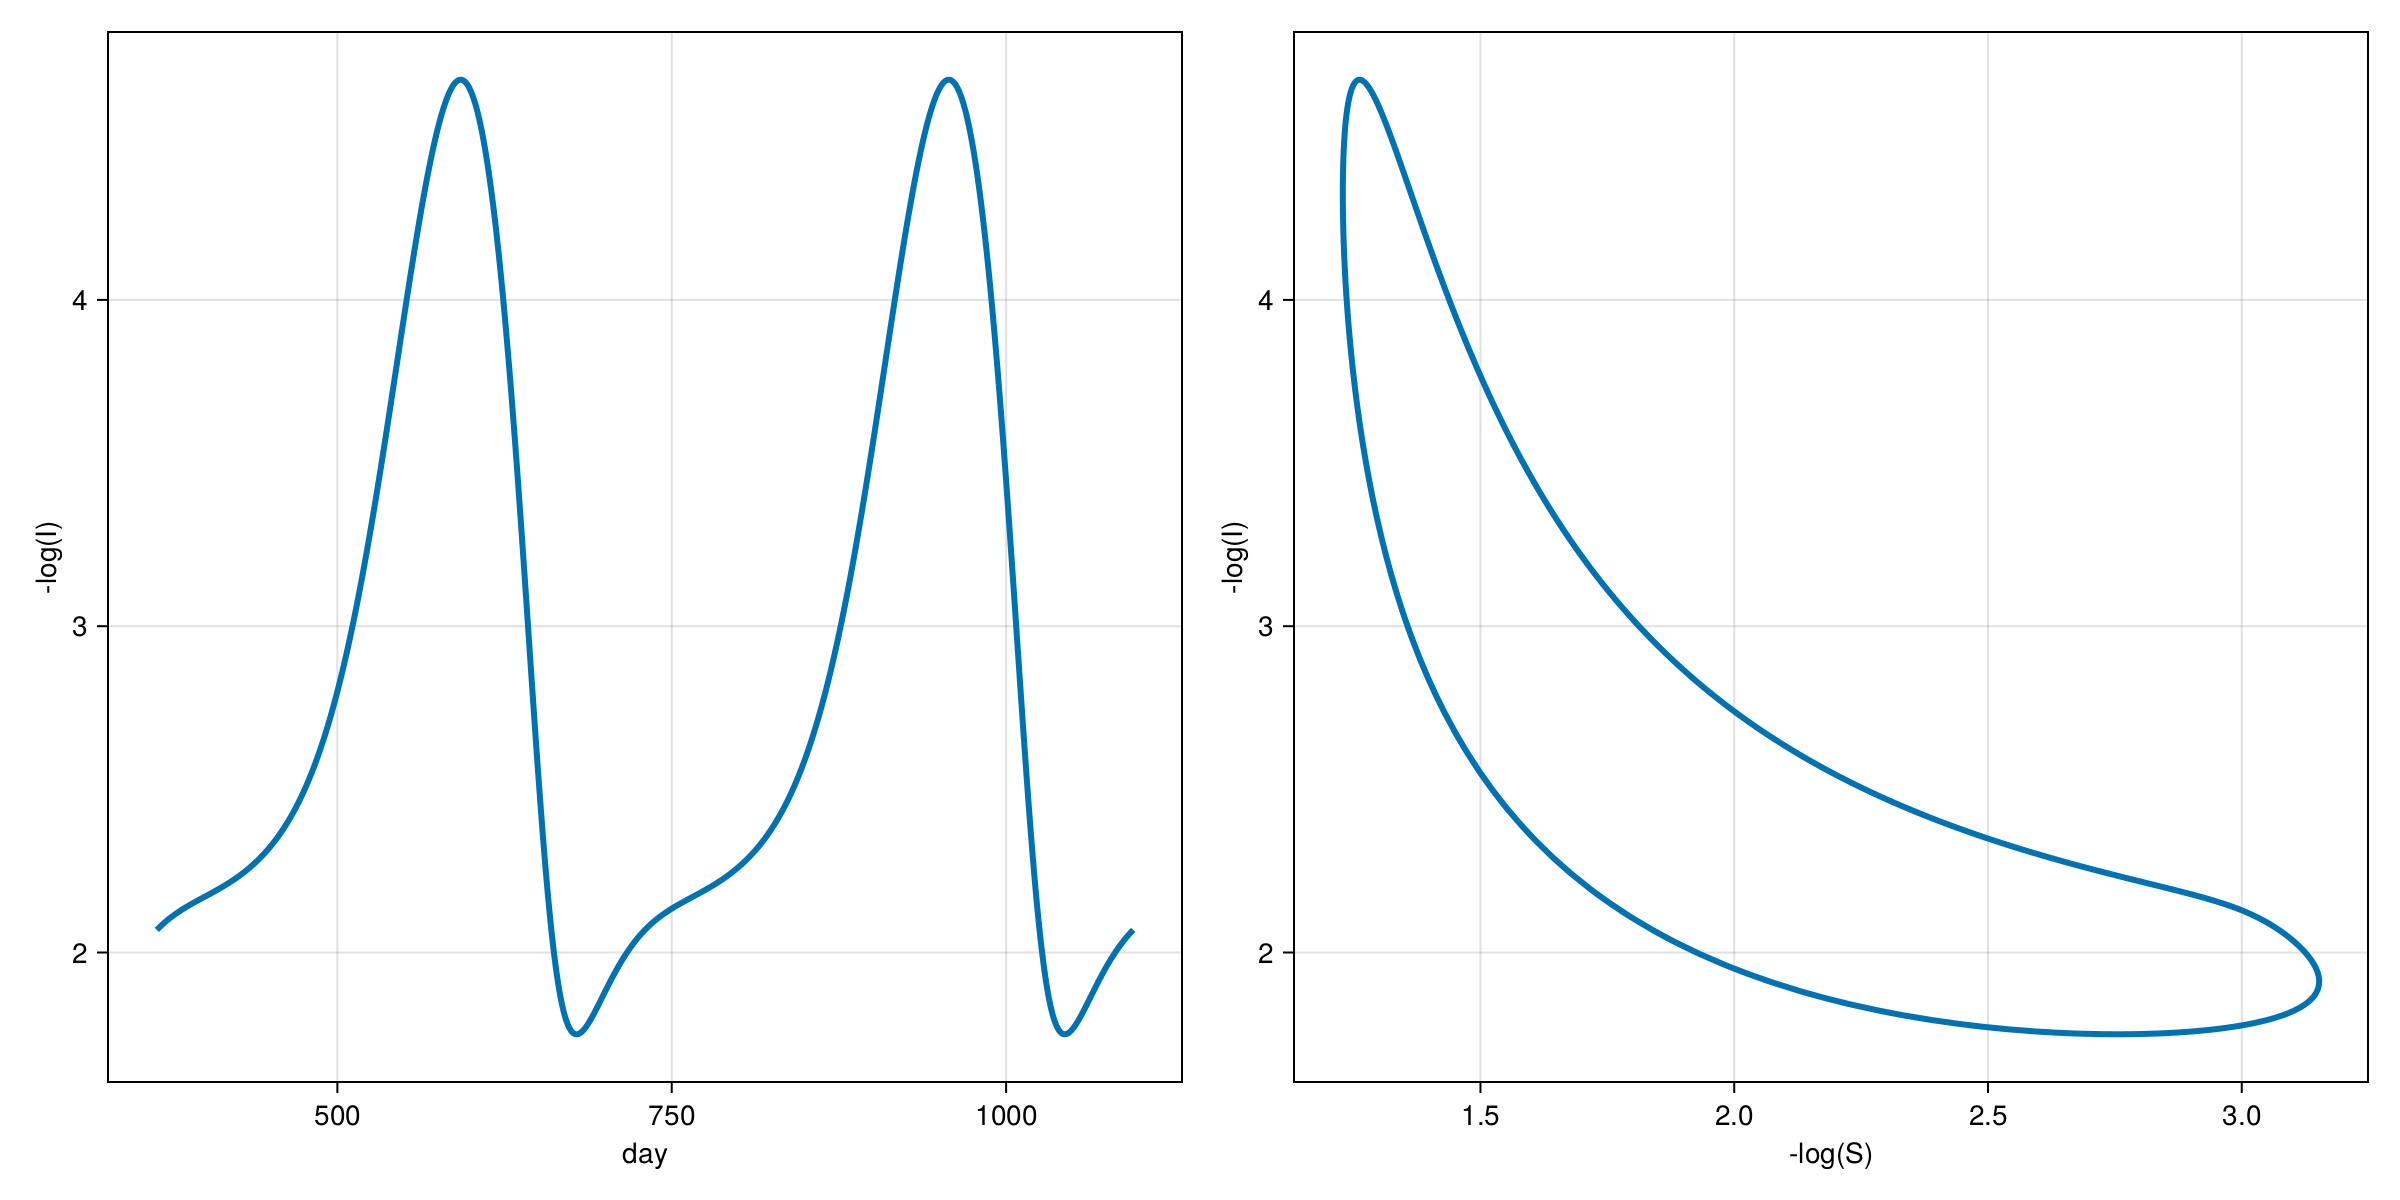

In [13]:
β₁ = 0.9
model = SIRVSeasonalContactDecayingImmunity(β₁, ν, α, μ)
plot_phase_diagram(model, endtime = 2 * 365.0, Ttr = 365.0)

- While the dynamics begin to look interesting for large (perhaps unrealistic) values of β₁, with the peaks and troughs also becoming more severe, we nonetheless consistently observe the same annual periodicity as the forcing. That is, we don't see any period doubling bifurcations or chaos, like we did for a similar model in the lecture. Interesting!